# Validate Moral Judgment Signature (MJS)

In this notebook we perform the following analysis steps:
1. Application of MJS to vignette timeseries
2. Application of MJS to each vignette item 

In [1]:
import os, math
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix

from joblib import Parallel, delayed
from scipy.stats import ttest_ind,pearsonr,spearmanr

# Set Paths and Variables

In [2]:
spectral = sns.color_palette("Spectral_r", n_colors=8, as_cmap=False)
rating_pal = [spectral[0],spectral[1], spectral[5], spectral[-1]]
sns.set_context('paper', font_scale=2)

In [3]:
## Discovery
disc_peristim = "/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/peristimulus/discovery/sub*"
disc_betas = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_1/'

## Validation
valid_peristim = "/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/peristimulus/validation/sub*"
valid_betas = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/ucsb_2/'

## Replication
repl_peristim = "/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/peristimulus/replication/sub*"
repl_betas = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/duke/'

## Generalization
gen_peristim = "/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/peristimulus/generalization/sub*"
gen_betas = '/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/glm/uva/'

*** 
# Peristimulus Plots

Here we only visualize the results. See code `peristimulus.py` for applying the MJS to the fMRI data. 

In [15]:
def plot_peristimulus(input_dir, output_path):
    
    # Load the pattern expression data 
    files = glob.glob(input_dir)
    files.sort()
    dfs = []
    for f in files:
        df = pd.read_csv(f, index_col=0)
        df['subject'] = f.split('/')[-1].split('.')[0]
        dfs.append(df)
        
    pexp = pd.concat(dfs)
    pexp = pexp[pexp['TR']<21]
    pexp = pexp.dropna()
    
    # Make the plot
    fig, ax = plt.subplots(figsize=(5,4.5))
    sns.lineplot(x='TR', y='pexp', hue='rating',  marker='o', markers=True, 
                    dashes=False, data=pexp,  palette=rating_pal, errorbar='se', **{'markersize':10}, )
    sns.despine()
    # ylabel close to plot
    ax.yaxis.set_label_coords(-0.1,0.5)
    plt.ylabel('MJS pattern expression', fontsize=15)
    plt.xlabel('TR (0.72s)', fontsize=15)
    ax.get_legend().remove()
    plt.yticks(np.arange(-0.5, 1.5, 0.5), fontsize=12)
    ax.set_yticklabels(['-.5','0','.5','1'],fontsize=12)
    # Change xtick label size
    plt.xticks(fontsize=12)
    # plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    return

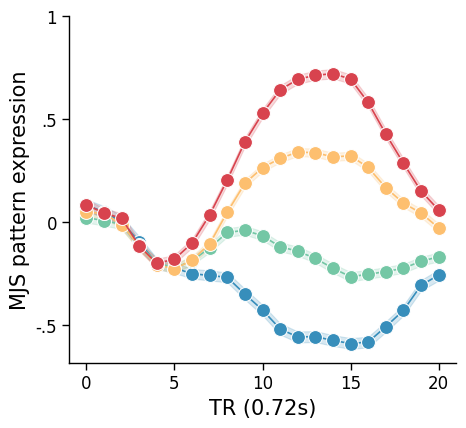

In [16]:
# Discovery Cohort (LOSO Cross-Validated)
plot_peristimulus(disc_peristim, 'plots/peristimulus_s1.png')

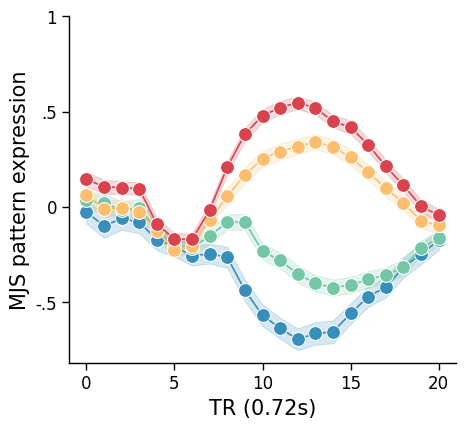

In [17]:
# Validation Cohort
plot_peristimulus(valid_peristim, 'plots/peristimulus_s2.png')

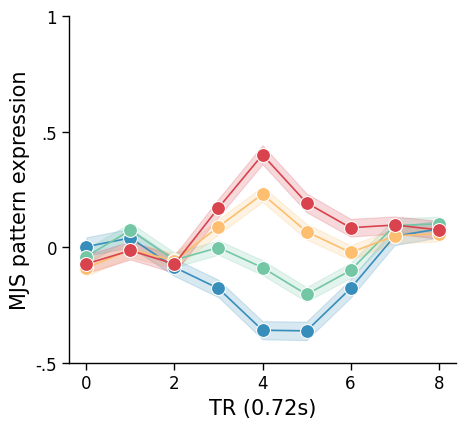

In [18]:
# Replication Cohort
plot_peristimulus(repl_peristim, 'plots/peristimulus_s3.png')

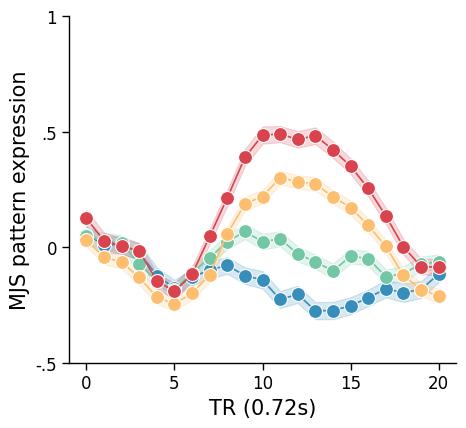

In [19]:
# Generalization Cohort
plot_peristimulus(gen_peristim, 'plots/peristimulus_s4.png')

***
# Within-subject trial-wise predictions

We performed single-trial analyses using the Least Squares All (LSA) approach (see `03_glm_trial.py`) to obtain a beta map for each vignette for each subject in each study. The MJS was next applied to these beta maps (see below) to calculate the pattern expressions which were further correlated with the true ratings for each subject separately. The statistical signiﬁcance was evaluated by prediction−outcome Pearson correlation for each subject separately.

In [22]:
def score_betas_pattern(sub, cohort, cross_val, p_name):
    # cross_val only with MJS!
    if cross_val==True:
        xval = pd.read_csv('weightmaps/mjs/mjs_xval_split.csv')
        xval_ix = int(xval.loc[:, (xval[xval['Subject']==sub]==0).all()].columns[0].split('_')[1])
        pattern = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights_xval.nii.gz')[xval_ix]
    else:
        if p_name == 'mjs':
            pattern = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/mjs/mjs_weights.nii.gz')
        if p_name == 'pines':
            pattern = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/external/PINES.nii.gz')
        if p_name == 'vids':
            pattern = Brain_Data('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/weightmaps/external/VIDS.nii')

    sub_df = sub_info[sub_info['subject']==sub]
    for i,row in sub_df.iterrows():
        betas = Brain_Data(row['file'])
        sub_df.loc[i, f'{p_name}+_pexp'] = betas.similarity(pattern, method='dot_product')
    sub_df.to_csv(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/{cohort}/{p_name}_{sub}.csv")

In [27]:
import numpy as np
from scipy.stats import norm
from scipy.stats import bootstrap

def jackknife_resampling(data, stat_fun):
    n = len(data)
    jack_samples = np.zeros(n)
    
    for i in range(n):
        jackknife_sample = np.delete(data, i)
        jack_samples[i] = stat_fun(jackknife_sample)
    
    return jack_samples

def bootbca_pval(testvalue, bootfun, bstat=None, stat=None, *args):
    """
    Calculate p-values using the bias-corrected and accelerated (BCa) bootstrap method.
    
    Parameters:
    - testvalue: Value to test (e.g., 0 for hypothesis testing)
    - bootfun: Function to bootstrap (e.g., np.mean)
    - bstat: Bootstrap statistics (optional)
    - stat: Statistic from original sample (optional)
    - *args: Additional inputs to bootfun
    
    Returns:
    - p: P-value
    - z: Bias-corrected z-score
    """
    if bstat is None or stat is None:
        stat = bootfun(*args)
        bstat = bootstrap((np.array(args[0]),), bootfun, n_resamples=1000).bootstrap_distribution

    B, ncols = bstat.shape if bstat.ndim > 1 else (len(bstat), 1)

    # Bias correction
    prop_less = np.sum(bstat < stat, axis=0) / B
    z_0 = norm.ppf(prop_less)

    # Jackknife resampling
    jstat = jackknife_resampling(np.array(args[0]), bootfun)
    n = len(jstat)
    score = -(jstat - np.mean(jstat, axis=0))
    skew = np.sum(score**3) / (np.sum(score**2)**1.5)
    a = skew / 6  # Acceleration factor

    # Percentile calculations
    pct_lowertail = np.sum(bstat < testvalue, axis=0) / B
    pct_uppertail = np.sum(bstat > testvalue, axis=0) / B

    is_lowertail = pct_lowertail < pct_uppertail

    # Adjust to avoid extreme values
    pct_lowertail = np.clip(pct_lowertail, 1 / B, 1 - 1 / B)
    pct_uppertail = np.clip(pct_uppertail, 1 / B, 1 - 1 / B)

    # Bias-corrected z-scores
    zpct_lowertail = norm.ppf(pct_lowertail) - z_0
    zpct_uppertail = norm.ppf(pct_uppertail) - z_0

    z_lowertail = (zpct_lowertail * (1 - a * z_0) - z_0) / (1 + a * zpct_lowertail)
    z_uppertail = (zpct_uppertail * (1 - a * z_0) - z_0) / (1 + a * zpct_uppertail)

    z = np.where(is_lowertail, -z_lowertail, z_uppertail)

    # Calculate p-values
    p = norm.cdf(z)
    p = np.vstack((p, 1 - p))
    p = 2 * np.min(p, axis=0)

    return p, z

In [32]:
def plot_trials(betas_dir, cohort, study, output_path, analysis):
    
    # Load the data
    betas = [x for x in glob.glob(betas_dir+'sub*') if 'item' in x]
    betas.sort()

    sub_info = pd.DataFrame()
    sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
    sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
    sub_info['file'] = betas
    sub_info['pexp'] = 0.0

    sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')
    # Apply MJS to patterns (only need to be run once)
    # Parallel(n_jobs=-1)(delayed(score_betas_mjs)(sub,True) for sub in sub_info['subject'].unique())

    # Load all csv into a single dataframe
    scored_dfs = []
    for sub in sub_info['subject'].unique():
        sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/{cohort}/*") if sub in x][0]
        sub_df = pd.read_csv(sub_file, index_col=0)
        scored_dfs.append(sub_df)
    scored_dfs = pd.concat(scored_dfs)
    scored_dfs['pexp'] = zscore(scored_dfs['pexp'])

    # Load behavior 
    beh_dir = f'/srv/lab/fmri/mofomic/{study}'
    beh_files = glob.glob(os.path.join(beh_dir, 'sub-*/beh/sub-*_task-mfv_*_beh.tsv'))
    vig_beh_dfs = []
    for file in beh_files:
        df = pd.read_csv(file, sep='\t')
        df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
        vig_beh_dfs.append(df)
    df_beh = pd.concat(vig_beh_dfs).reset_index(drop=True)
    df_beh = df_beh.dropna()
    df_beh = df_beh[['sub_id','moral_decision','cond_id']]
    df_beh = df_beh.rename(columns={'cond_id':'vignette'})

    # Join 
    scored_dfs = scored_dfs.merge(df_beh, left_on=['subject','vignette'], right_on=['sub_id','vignette'])

    if analysis == 'subject':
        # Compute subject-level correlations
        sub_rs = pd.DataFrame(columns=['subject', 'r', 'p'])
        for sub in scored_dfs['subject'].unique():
            sub_data = scored_dfs[scored_dfs['subject']==sub]
            r, p = pearsonr(sub_data['moral_decision'], sub_data['pexp'])
            sub_rs.at[sub, 'subject'] = sub
            sub_rs.at[sub, 'r'] = r
            sub_rs.at[sub, 'p'] = p
        sub_rs['sig'] = sub_rs['p'].apply(lambda x: x<0.05)
        sub_rs = sub_rs.reset_index(drop=True)

        print(sub_rs['sig'].value_counts())
        stat = sub_rs['r'].mean()
        bstat = bootstrap((sub_rs['r'].values,), np.mean, n_resamples=10000).bootstrap_distribution
        p, z = bootbca_pval(0, np.mean, bstat, stat, sub_rs['r'].values)
        print(f'Mean prediction-outcome correlation for {cohort} Cohort: ', "M=", round(stat,2), "SD=", round(sub_rs['r'].std(),2), "P=", p)

        # Sort sub_rs by 'r' in ascending order and reset the index
        sub_rs_sorted = sub_rs.sort_values(by='r', ascending=False).reset_index(drop=True)
        if len(sub_rs_sorted) > 30:
            n_rows = 4
            n_cols = 16
        else:
            n_rows = 2
            n_cols = 15

        sub_r_matrix = np.zeros((n_rows, n_cols))

        # Fill matrix from left to right, starting with the first row, with ascending sub_rs_sorted['r']
        for i, row in sub_rs_sorted.iterrows():
            sub_r_matrix[i//n_cols, i%n_cols] = row['r']

        sns.heatmap(sub_r_matrix, cmap='Spectral_r', linewidths=2.5, square=True, vmin=0, vmax=1, cbar_kws={'label': 'Prediction-Outcome Correlation', 'orientation': 'horizontal'})
        # Turn off x and ticklabels
        plt.xticks([])
        plt.yticks([])
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.show()
    
    if analysis == 'item':
        # Item-level analyses
        items = scored_dfs.groupby('vignette')[['moral_decision','pexp']].mean().reset_index()
        items['Condition'] = items['vignette'].apply(lambda x: x[:-2])
        for cond in items['Condition'].unique():
            cond_items = items[items['Condition']==cond]
            cond_r, cond_p = pearsonr(cond_items['moral_decision'], cond_items['pexp'])
            print(f'Condition: {cond}, r: {round(cond_r,2)}, p: {cond_p}')
        print('---------------------')
        item_r, item_p = pearsonr(items['moral_decision'], items['pexp'])

        
        moral_only = items[items['Condition']!='social_norms']
        moral_r, moral_p = pearsonr(moral_only['moral_decision'], moral_only['pexp'])
        print('Moral-Only: ', moral_r, moral_p)
        
        if cohort == 'validation':
            # just mac items
            mac_cond = ['family', 'group', 'reciprocity', 'property', 'fairness', 'heroism', 'deference']
            mac_items = items[items['Condition'].isin(mac_cond)]
            mac_r, mac_p = pearsonr(mac_items['moral_decision'], mac_items['pexp'])
            print('Validation Cohort MAC-Only: ', mac_r, mac_p)

        # Sort items by average wrongness level for later color-coding
        items_sorted = items.groupby('Condition')[['moral_decision']].mean().sort_values(by='moral_decision', ascending=False)
        print('Order of sorted conditions: ', items_sorted.index.values)
        
        spectral = sns.color_palette("Spectral", n_colors=len(items_sorted.index), as_cmap=False)
        # Assign colors according to level of moral wrongness
        hue_colors = {}
        for i, hue in enumerate(items_sorted.index):
            hue_colors[hue] = spectral[i]

        plt.subplots(figsize=(5.5,3.5))

        ax = sns.regplot(x='pexp', y='moral_decision', data=items, scatter=False, color='black', line_kws={'lw': 3})
        ax = sns.scatterplot(x='pexp', y='moral_decision', data=items, legend=True)
        
        sns.despine()
        plt.ylabel('Average Vignette Rating', fontsize=15)
        plt.xlabel('Average MJS Pattern Expression', fontsize=15)
        plt.yticks(np.arange(0, 5, 1), fontsize=12)
        # Make xticks bold
        plt.xticks(fontsize=12)
        ax.xaxis.set_major_locator(MaxNLocator(nbins='auto', integer=True))

        ax.text(items['pexp'].min()+0.05, 4, r'$\mathrm{{r}} = {}, P < {} \times 10^{{-{}}}$'.format(round(item_r, 2), str(item_p)[0:4], str(item_p)[-2:]), 
                color='black', fontsize=12)

        for i in range(len(items)):
            hue = items.loc[i, 'Condition']
            color = hue_colors[hue]
            ax.scatter(items.loc[i, 'pexp'], items.loc[i, 'moral_decision'], color=color, s=40)

        # plt.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.show()

sig
True     61
False     3
Name: count, dtype: int64
Mean prediction-outcome correlation for discovery Cohort:  M= 0.44 SD= 0.15 P= [0.00026455]


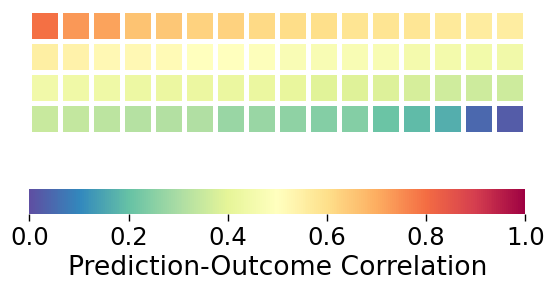

In [33]:
plot_trials(disc_betas, 'discovery', 'ucsb_1', '../../plots/sub_rs_disc_heatmap.png', 'subject')

sig
True     25
False     5
Name: count, dtype: int64
Mean prediction-outcome correlation for validation Cohort:  M= 0.34 SD= 0.11 P= [0.00017581]


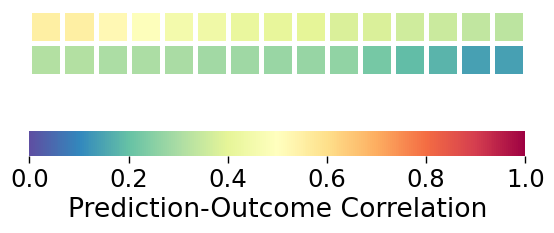

In [34]:
plot_trials(valid_betas, 'validation', 'ucsb_2', '../../plots/sub_rs_val_heatmap.png', 'subject')

sig
False    16
True     11
Name: count, dtype: int64
Mean prediction-outcome correlation for replication Cohort:  M= 0.17 SD= 0.12 P= [0.00022574]


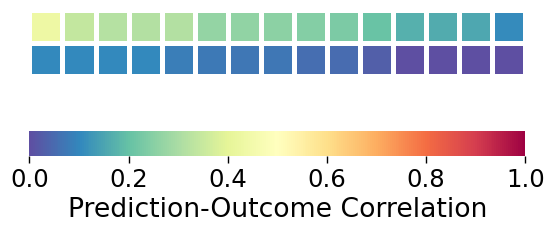

In [35]:
plot_trials(repl_betas, 'replication', 'duke', '../../plots/sub_rs_repl_heatmap.png', 'subject')

sig
True     21
False     9
Name: count, dtype: int64
Mean prediction-outcome correlation for generalization Cohort:  M= 0.22 SD= 0.14 P= [0.00044778]


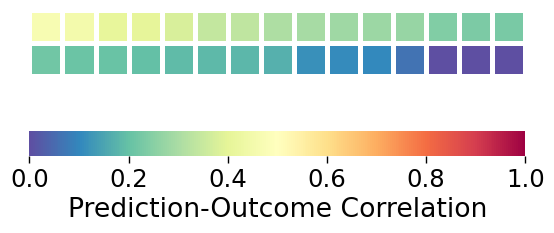

In [36]:
plot_trials(gen_betas, 'generalization', 'uva', '../../plots/sub_rs_gen_heatmap.png', 'subject')

***
# Item-analysis

## Discovery

Condition: authority, r: 0.25, p: 0.3784515248936985
Condition: care_emotional, r: 0.8, p: 0.00033718320352038724
Condition: care_physical, r: 0.62, p: 0.013087431355030243
Condition: fairness, r: 0.8, p: 0.00029523740744863473
Condition: liberty, r: 0.75, p: 0.0012629832243612222
Condition: loyalty, r: 0.01, p: 0.9633037259502099
Condition: sanctity, r: 0.71, p: 0.0027920199032261416
Condition: social_norms, r: 0.26, p: 0.35470599369914274
---------------------
Moral-Only:  0.7465375516865818 6.193041581022506e-20
Order of sorted conditions:  ['care_physical' 'fairness' 'sanctity' 'liberty' 'care_emotional'
 'authority' 'loyalty' 'social_norms']


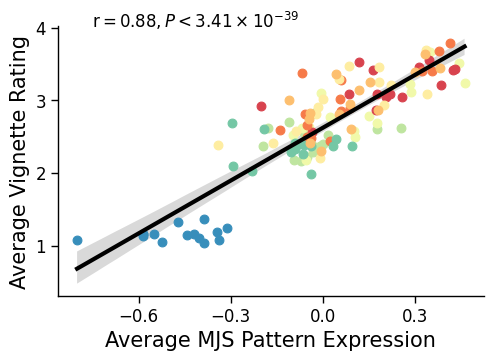

In [13]:
plot_trials(disc_betas, 'discovery', 'ucsb_1', 'plots/mjs_s1_items.png', 'item')

Condition: authority, r: 0.58, p: 0.1688119737929632
Condition: care_emotional, r: -0.18, p: 0.8825615026769451
Condition: care_physical, r: -0.27, p: 0.7265899187221734
Condition: deference, r: 0.65, p: 0.2390300451139534
Condition: fairness, r: 0.88, p: 0.008710909154996062
Condition: family, r: -0.08, p: 0.8944463789532069
Condition: group, r: 0.47, p: 0.4292905270796364
Condition: heroism, r: 0.89, p: 0.04344583500533868
Condition: loyalty, r: 0.69, p: 0.08418986953092772
Condition: property, r: 0.19, p: 0.757302123014365
Condition: reciprocity, r: 0.93, p: 0.02040168828320014
Condition: sanctity, r: 0.95, p: 0.0009364364005958866
Condition: social_norms, r: -0.26, p: 0.5782099815885975
---------------------
Moral-Only:  0.7210921909353312 1.2486118759388748e-11
Validation Cohort MAC-Only:  0.6363493593956459 2.3016859081729583e-05
Order of sorted conditions:  ['family' 'care_physical' 'care_emotional' 'group' 'sanctity'
 'reciprocity' 'property' 'fairness' 'heroism' 'deference' 'a

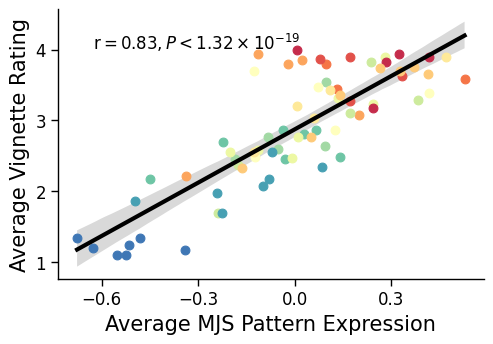

In [14]:
plot_trials(valid_betas, 'validation', 'ucsb_2', 'plots/mjs_s2_items.png', 'item')

Condition: authority, r: -0.16, p: 0.56380881044289
Condition: care_emotional, r: 0.23, p: 0.3997980130036825
Condition: care_physical, r: 0.25, p: 0.3592611903710368
Condition: fairness, r: 0.28, p: 0.31098683921643616
Condition: liberty, r: 0.28, p: 0.3072963013066267
Condition: loyalty, r: -0.37, p: 0.17803028590574596
Condition: sanctity, r: 0.79, p: 0.00044942684756454286
Condition: social_norms, r: 0.14, p: 0.6247554772433481
---------------------
Moral-Only:  0.4551785959674321 1.0689307343281426e-06
Order of sorted conditions:  ['sanctity' 'care_physical' 'fairness' 'care_emotional' 'liberty'
 'authority' 'loyalty' 'social_norms']


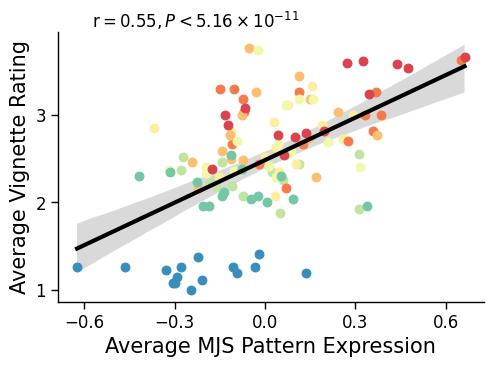

In [15]:
plot_trials(repl_betas, 'replication', 'duke', 'plots/mjs_s3_items.png', 'item')

Condition: authority, r: -0.25, p: 0.36386242569820837
Condition: care_emotional, r: 0.25, p: 0.37797334839370716
Condition: care_physical, r: 0.21, p: 0.44392477715337997
Condition: fairness, r: 0.04, p: 0.901065710877715
Condition: liberty, r: 0.13, p: 0.6351605557871863
Condition: loyalty, r: 0.34, p: 0.20893845447360015
Condition: sanctity, r: 0.51, p: 0.04981854162042599
Condition: social_norms, r: -0.24, p: 0.38171165416903124
---------------------
Moral-Only:  0.4710995452026397 3.937381181167718e-07
Order of sorted conditions:  ['care_physical' 'liberty' 'fairness' 'sanctity' 'care_emotional'
 'authority' 'loyalty' 'social_norms']


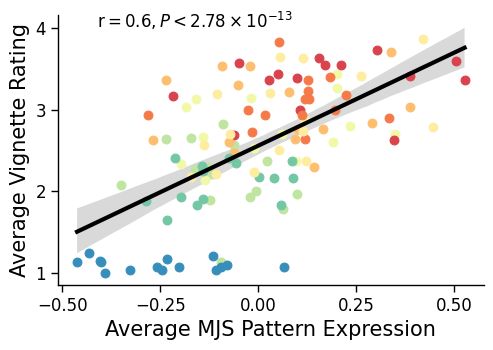

In [16]:
plot_trials(gen_betas, 'generalization', 'uva', 'plots/mjs_s4_items.png', 'item')

### Out-of-sample wrongness prediction for U.S. population

Data collected by Clifford et al. (2015) and available from [Khoudary et al., 2015](https://github.com/IMC-Lab/mft_memory/tree/master).

In [47]:
betas = [x for x in glob.glob(gen_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/discovery/*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
scored_dfs['pexp'] = zscore(scored_dfs['pexp'])

scored_dfs = scored_dfs.groupby('vignette')['pexp'].mean().reset_index()

In [60]:
mfv_us_mapper = {'auth':'authority', 
                'careemo': 'care_emotional',
                'carephys':'care_physical',
                'fairness':'fairness',
                'lib':'liberty',
                'loy':'loyalty',
                'pur':'sanctity',
                'socnorm':'social_norms',

}

mfv_us = pd.read_csv("/srv/lab/fmri/mft/mf_duke/behavior/mft_memory/data/mfv_norms.csv", usecols=['vigfile', 'moral_decision'])
for i, row in mfv_us.iterrows():
    for key, value in mfv_us_mapper.items():
        try:
            if row['vigfile'].startswith(key):
                mfv_us.at[i, 'vigfile'] = row['vigfile'].replace(key, value)
        except:
            pass

mfv_us = mfv_us.rename(columns={'vigfile':'vignette'})
mfv_us = mfv_us.dropna()
mfv_us = mfv_us.merge(scored_dfs, on='vignette', how='inner')

us_r, us_p = pearsonr(mfv_us['pexp'], mfv_us['moral_decision'])
print('Out-of-sample correlation: ', round(us_r, 2), round(us_p,10))

Out-of-sample correlation:  0.79 0.0


### Out-of-sample wrongness prediction for Dutch population

Data available from [Hopp et al., 2024](https://osf.io/9gnza/).

In [15]:
betas = [x for x in glob.glob(gen_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/generalization/*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
scored_dfs['pexp'] = zscore(scored_dfs['pexp'])

In [49]:
nl_cond_mapper = {
    "Physical Care": "care_physical",
    "Emotional Care": "care_emotional",
    "Social Norms": "social_norms",
}

nl_mfv = pd.read_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/beh_data/hopp_dutch_ratings.csv',
                     index_col=0)
nl_mfv_long = nl_mfv.melt(value_vars=['moral wrongness'], id_vars=['Condition','item'], value_name='pop_rating')

nl_mfv_long = nl_mfv_long.rename(columns={'Condition':'MFV condition'})
for i, row in nl_mfv_long.iterrows():
    if row['MFV condition'] == 'Physical Care':
        nl_mfv_long.at[i, 'MFV condition'] = 'care_physical'
    elif row['MFV condition'] == 'Emotional Care':
        nl_mfv_long.at[i, 'MFV condition'] = 'care_emotional'
    elif row['MFV condition'] == 'Social Norms':
        nl_mfv_long.at[i, 'MFV condition'] = 'social_norms'
    else:
        nl_mfv_long.at[i, 'MFV condition'] = row['MFV condition'].lower()

nl_mfv_long['vignette'] = nl_mfv_long['MFV condition'] + nl_mfv_long['item'].apply(lambda x: x[-2:])


# #### Concat with Emotion Ratings
df_merged = scored_dfs.groupby('vignette')[['pexp']].mean().reset_index().merge(nl_mfv_long[['vignette','pop_rating']], on='vignette')
nl_r, nl_p = pearsonr(df_merged['pexp'], df_merged['pop_rating'])
print('Out-of-sample correlation: ', round(nl_r, 2), round(nl_p,10))

Out-of-sample correlation:  0.58 0.0


***

# Extract trial-wise predictions (MJS, PINES, and VIDS) for mediation analysis in MATLAB

In [4]:
import scipy.io

## Discovery Cohort

In [8]:
# Score betas for each subject
betas = [x for x in glob.glob(disc_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

In [9]:
scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/discovery/mjs*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
disc_PE = pd.concat(scored_dfs)

disc_PE['mjs_pexp'] = zscore(disc_PE['pexp'])
del disc_PE['pexp']

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/discovery/pines*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
disc_PE['pines_pexp'] = zscore(scored_dfs['pexp'])

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/discovery/vids*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
disc_PE['vids_pexp'] = zscore(scored_dfs['pexp'])

# Load behavior 
beh_dir = f'/srv/lab/fmri/mofomic/ucsb_1'
beh_files = glob.glob(os.path.join(beh_dir, 'sub-*/beh/sub-*_task-mfv_*_beh.tsv'))
vig_beh_dfs = []
for file in beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
df_beh = pd.concat(vig_beh_dfs).reset_index(drop=True)
df_beh = df_beh.dropna()
df_beh = df_beh[['sub_id','moral_decision','cond_id']]
df_beh = df_beh.rename(columns={'cond_id':'vignette'})

disc_PE = disc_PE.merge(df_beh, left_on=['subject','vignette'], right_on=['sub_id','vignette'])
del disc_PE['sub_id']
del disc_PE['file']

In [10]:
disc_PE

,subject,vignette,mjs_pexp,pines_pexp,vids_pexp,moral_decision
0,sub-01,authority01,-0.089629,-2.244255,-1.101695,3.0
1,sub-01,authority02,0.309116,-0.441153,-0.044298,3.0
2,sub-01,authority03,-0.278579,-0.763085,0.051451,2.0
3,sub-01,authority04,-0.462906,-1.639526,0.706184,2.0
4,sub-01,authority05,-1.420513,-1.219965,0.295542,2.0
...,...,...,...,...,...,...
7296,sub-64,social_norms11,0.265857,-0.138196,0.659837,1.0
7297,sub-64,social_norms12,-0.104144,1.272269,0.291955,1.0
7298,sub-64,social_norms13,0.588594,0.133055,0.197127,1.0
7299,sub-64,social_norms14,0.121971,-0.189620,0.431779,1.0


In [ ]:
disc_PE.to_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/disc_PE.csv')

In [ ]:
disc_ratings = {i: [] for i, x in enumerate(disc_PE['subject'].unique())}
for i, sub in enumerate(disc_PE['subject'].unique()):
    sub_df = disc_PE[disc_PE['subject']==sub]
    disc_ratings[i] = list(sub_df['moral_decision'])
# Create object array for MATLAB cell
values = np.empty((1, len(disc_ratings)), dtype=object)

for i, v in enumerate(disc_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('disc_ratings.mat', {'disc_ratings': values})

disc_ratings = {i: [] for i, x in enumerate(disc_PE['subject'].unique())}
for i, sub in enumerate(disc_PE['subject'].unique()):
    sub_df = disc_PE[disc_PE['subject']==sub]
    disc_ratings[i] = list(sub_df['mjs_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(disc_ratings)), dtype=object)

for i, v in enumerate(disc_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('disc_mjs_PE.mat', {'disc_MJS': values})

disc_ratings = {i: [] for i, x in enumerate(disc_PE['subject'].unique())}
for i, sub in enumerate(disc_PE['subject'].unique()):
    sub_df = disc_PE[disc_PE['subject']==sub]
    disc_ratings[i] = list(sub_df['pines_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(disc_ratings)), dtype=object)

for i, v in enumerate(disc_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('disc_pines_PE.mat', {'disc_PINES': values})

## Validation Cohort 

In [11]:
# Score betas for each subject
betas = [x for x in glob.glob(valid_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

In [18]:
scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/validation/sub*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
valid_PE = pd.concat(scored_dfs)

valid_PE['mjs_pexp'] = zscore(valid_PE['pexp'])
del valid_PE['pexp']

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/validation/pines*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
valid_PE['pines_pexp'] = zscore(scored_dfs['pines+_pexp'])

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/validation/vids*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
valid_PE['vids_pexp'] = zscore(scored_dfs['vids+_pexp'])

# Load behavior 
beh_dir = f'/srv/lab/fmri/mofomic/ucsb_2'
beh_files = glob.glob(os.path.join(beh_dir, 'sub-*/beh/sub-*_task-mfv_*_beh.tsv'))
vig_beh_dfs = []
for file in beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
df_beh = pd.concat(vig_beh_dfs).reset_index(drop=True)
df_beh = df_beh.dropna()
df_beh = df_beh[['sub_id','moral_decision','cond_id']]
df_beh = df_beh.rename(columns={'cond_id':'vignette'})

valid_PE = valid_PE.merge(df_beh, left_on=['subject','vignette'], right_on=['sub_id','vignette'])
del valid_PE['sub_id']
del valid_PE['file']

In [19]:
valid_PE

,subject,vignette,mjs_pexp,pines_pexp,vids_pexp,moral_decision
0,sub-02,authority03,-0.781662,0.432741,0.829758,4.0
1,sub-02,authority05,-0.734131,0.909658,-1.005143,2.0
2,sub-02,authority07,-0.896674,1.462429,-0.066235,4.0
3,sub-02,authority08,-0.706855,0.022348,-0.377955,3.0
4,sub-02,authority11,-0.443181,0.069461,1.095975,3.0
...,...,...,...,...,...,...
2090,sub-33,social_norms06,-0.210501,0.810176,-0.599177,1.0
2091,sub-33,social_norms07,-0.255073,0.029956,-0.302953,1.0
2092,sub-33,social_norms10,1.163714,-0.299340,-0.025005,1.0
2093,sub-33,social_norms13,-1.659867,-0.877220,-0.391609,1.0


In [20]:
valid_PE.to_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/valid_PE.csv')

In [21]:
valid_ratings = {i: [] for i, x in enumerate(valid_PE['subject'].unique())}
for i, sub in enumerate(valid_PE['subject'].unique()):
    sub_df = valid_PE[valid_PE['subject']==sub]
    valid_ratings[i] = list(sub_df['moral_decision'])
# Create object array for MATLAB cell
values = np.empty((1, len(valid_ratings)), dtype=object)

for i, v in enumerate(valid_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('valid_ratings.mat', {'valid_ratings': values})

valid_ratings = {i: [] for i, x in enumerate(valid_PE['subject'].unique())}
for i, sub in enumerate(valid_PE['subject'].unique()):
    sub_df = valid_PE[valid_PE['subject']==sub]
    valid_ratings[i] = list(sub_df['mjs_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(valid_ratings)), dtype=object)

for i, v in enumerate(valid_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('valid_mjs_PE.mat', {'valid_MJS': values})

valid_ratings = {i: [] for i, x in enumerate(valid_PE['subject'].unique())}
for i, sub in enumerate(valid_PE['subject'].unique()):
    sub_df = valid_PE[valid_PE['subject']==sub]
    valid_ratings[i] = list(sub_df['pines_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(valid_ratings)), dtype=object)

for i, v in enumerate(valid_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('valid_pines_PE.mat', {'valid_PINES': values})

## Replication Cohort

In [23]:
# Score betas for each subject
betas = [x for x in glob.glob(repl_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

In [27]:
# Parallel(n_jobs=-1)(delayed(score_betas_pattern)(sub, 'replication', False, 'pines') for sub in sub_info['subject'].unique())
# Parallel(n_jobs=-1)(delayed(score_betas_pattern)(sub, 'replication', False, 'vids') for sub in sub_info['subject'].unique())

In [28]:
scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/replication/sub*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
repl_PE = pd.concat(scored_dfs)

repl_PE['mjs_pexp'] = zscore(repl_PE['pexp'])
del repl_PE['pexp']

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/replication/pines*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
repl_PE['pines_pexp'] = zscore(scored_dfs['pines+_pexp'])

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/replication/vids*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
repl_PE['vids_pexp'] = zscore(scored_dfs['vids+_pexp'])

# Load behavior 
beh_dir = f'/srv/lab/fmri/mofomic/duke'
beh_files = glob.glob(os.path.join(beh_dir, 'sub-*/beh/sub-*_task-mfv_*_beh.tsv'))
vig_beh_dfs = []
for file in beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
df_beh = pd.concat(vig_beh_dfs).reset_index(drop=True)
df_beh = df_beh.dropna()
df_beh = df_beh[['sub_id','moral_decision','cond_id']]
df_beh = df_beh.rename(columns={'cond_id':'vignette'})

repl_PE = repl_PE.merge(df_beh, left_on=['subject','vignette'], right_on=['sub_id','vignette'])
del repl_PE['sub_id']
del repl_PE['file']

In [29]:
repl_PE

,subject,vignette,mjs_pexp,pines_pexp,vids_pexp,moral_decision
0,sub-07,authority01,-0.234518,0.108943,0.392233,2.0
1,sub-07,authority02,0.325829,-0.851695,0.434301,2.0
2,sub-07,authority03,-0.462957,1.906464,-0.220533,2.0
3,sub-07,authority04,-0.538142,-0.058914,-0.623284,2.0
4,sub-07,authority05,0.238800,-0.001832,0.367074,2.0
...,...,...,...,...,...,...
3154,sub-41,social_norms11,0.697716,0.935866,0.188385,1.0
3155,sub-41,social_norms12,-0.716816,-0.709491,-0.247721,1.0
3156,sub-41,social_norms13,0.116944,0.156329,0.228293,1.0
3157,sub-41,social_norms14,0.282632,-0.291855,0.978421,1.0


In [30]:
repl_PE.to_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/repl_PE.csv')

In [31]:
repl_ratings = {i: [] for i, x in enumerate(repl_PE['subject'].unique())}
for i, sub in enumerate(repl_PE['subject'].unique()):
    sub_df = repl_PE[repl_PE['subject']==sub]
    repl_ratings[i] = list(sub_df['moral_decision'])
# Create object array for MATLAB cell
values = np.empty((1, len(repl_ratings)), dtype=object)

for i, v in enumerate(repl_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('repl_ratings.mat', {'repl_ratings': values})

repl_ratings = {i: [] for i, x in enumerate(repl_PE['subject'].unique())}
for i, sub in enumerate(repl_PE['subject'].unique()):
    sub_df = repl_PE[repl_PE['subject']==sub]
    repl_ratings[i] = list(sub_df['mjs_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(repl_ratings)), dtype=object)

for i, v in enumerate(repl_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('repl_mjs_PE.mat', {'repl_MJS': values})

repl_ratings = {i: [] for i, x in enumerate(repl_PE['subject'].unique())}
for i, sub in enumerate(repl_PE['subject'].unique()):
    sub_df = repl_PE[repl_PE['subject']==sub]
    repl_ratings[i] = list(sub_df['pines_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(repl_ratings)), dtype=object)

for i, v in enumerate(repl_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('repl_pines_PE.mat', {'repl_PINES': values})

## Generalization Cohort

In [32]:
# Score betas for each subject
betas = [x for x in glob.glob(gen_betas+'sub*') if 'item' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['vignette'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['file'] = betas
sub_info['pexp'] = 0.0

sub_info['vignette'] = sub_info['vignette'].apply(lambda x: '_'.join(x)).str.replace('_c0','')

In [36]:
# Parallel(n_jobs=-1)(delayed(score_betas_pattern)(sub, 'generalization', False, 'pines') for sub in sub_info['subject'].unique())
# Parallel(n_jobs=-1)(delayed(score_betas_pattern)(sub, 'generalization', False, 'vids') for sub in sub_info['subject'].unique())

In [37]:
scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/generalization/sub*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
gen_PE = pd.concat(scored_dfs)

gen_PE['mjs_pexp'] = zscore(gen_PE['pexp'])
del gen_PE['pexp']

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/generalization/pines*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
gen_PE['pines_pexp'] = zscore(scored_dfs['pines+_pexp'])

scored_dfs = []
for sub in sub_info['subject'].unique():
    sub_file = [x for x in glob.glob(f"/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/within_sub_trialwise/generalization/vids*") if sub in x][0]
    sub_df = pd.read_csv(sub_file, index_col=0)
    scored_dfs.append(sub_df)
scored_dfs = pd.concat(scored_dfs)
gen_PE['vids_pexp'] = zscore(scored_dfs['vids+_pexp'])

# Load behavior 
beh_dir = f'/srv/lab/fmri/mofomic/uva'
beh_files = glob.glob(os.path.join(beh_dir, 'sub-*/beh/sub-*_task-mfv_*_beh.tsv'))
vig_beh_dfs = []
for file in beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
df_beh = pd.concat(vig_beh_dfs).reset_index(drop=True)
df_beh = df_beh.dropna()
df_beh = df_beh[['sub_id','moral_decision','cond_id']]
df_beh = df_beh.rename(columns={'cond_id':'vignette'})

gen_PE = gen_PE.merge(df_beh, left_on=['subject','vignette'], right_on=['sub_id','vignette'])
del gen_PE['sub_id']
del gen_PE['file']

In [38]:
gen_PE

,subject,vignette,mjs_pexp,pines_pexp,vids_pexp,moral_decision
0,sub-02,authority01,0.855142,-0.610288,-0.058430,3.0
1,sub-02,authority02,0.666019,0.188604,0.050613,1.0
2,sub-02,authority03,1.146324,-0.150939,-0.712203,3.0
3,sub-02,authority04,-0.252847,0.272887,0.270188,1.0
4,sub-02,authority05,-0.230355,1.392613,-0.951713,2.0
...,...,...,...,...,...,...
3512,sub-31,social_norms11,1.734115,1.255451,-2.918979,1.0
3513,sub-31,social_norms12,2.188388,1.664717,-3.703849,1.0
3514,sub-31,social_norms13,-2.495271,-3.707796,3.249074,1.0
3515,sub-31,social_norms14,2.141912,2.120480,-2.988927,1.0


In [39]:
gen_PE.to_csv('/srv/lab/fmri/mft/fhopp_diss/analysis/signature/results/sensitivity/gen_PE.csv')

In [40]:
gen_ratings = {i: [] for i, x in enumerate(gen_PE['subject'].unique())}
for i, sub in enumerate(gen_PE['subject'].unique()):
    sub_df = gen_PE[gen_PE['subject']==sub]
    gen_ratings[i] = list(sub_df['moral_decision'])
# Create object array for MATLAB cell
values = np.empty((1, len(gen_ratings)), dtype=object)

for i, v in enumerate(gen_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('gen_ratings.mat', {'gen_ratings': values})

gen_ratings = {i: [] for i, x in enumerate(gen_PE['subject'].unique())}
for i, sub in enumerate(gen_PE['subject'].unique()):
    sub_df = gen_PE[gen_PE['subject']==sub]
    gen_ratings[i] = list(sub_df['mjs_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(gen_ratings)), dtype=object)

for i, v in enumerate(gen_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('gen_mjs_PE.mat', {'gen_MJS': values})

gen_ratings = {i: [] for i, x in enumerate(gen_PE['subject'].unique())}
for i, sub in enumerate(gen_PE['subject'].unique()):
    sub_df = gen_PE[gen_PE['subject']==sub]
    gen_ratings[i] = list(sub_df['pines_pexp'])
# Create object array for MATLAB cell
values = np.empty((1, len(gen_ratings)), dtype=object)

for i, v in enumerate(gen_ratings.values()):
    v = np.asarray(v).reshape(-1, 1)  # 🔁 Reshape to (n, 1) column vector
    values[0, i] = v

scipy.io.savemat('gen_pines_PE.mat', {'gen_PINES': values})